In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'true'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.95'

import sys, os 
package_path = os.path.dirname(os.path.dirname(os.getcwd())) 
print(f'{package_path=}')
sys.path.insert(0, package_path)

from wofscast.model import WoFSCastModel
from wofscast.border_mask import BORDER_MASK_NUMPY

from wofscast.data_generator import load_chunk, dataset_to_input, add_local_solar_time

# For the diffusion model. 
from wofscast.normalization import PyTorchScaler
from wofscast.diffusion import apply_diffusion, EDMPrecond
from diffusers import UNet2DModel

# Utils for loading data, plotting, animations. 
from wofscast.common.mrms_data_loader import MRMSDataLoader 
from wofscast.common.helpers import (get_case_date, 
                                     to_datetimes, 
                                     get_qpe_datetimes, 
                                     border_difference_check
                                    ) 

from wofscast.common.plot_utils import WoFSCastAnimator, WoFSColors, WoFSLevels 

# To display the animation in a Jupyter notebook
from IPython.display import HTML

# For plotting. 
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
from glob import glob

package_path='/home/monte.flora/python_packages/frdd-wofs-cast'


##  Load the 5-min and 10-min WoFSCast Models

In [2]:
%%time 
# List of model paths
model_paths_10min = {
    'Corey\'s biggest model v178': '/work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz',
    'Corey\'s biggest model v207': '/work/cpotvin/WOFSCAST/model/wofscast_test_v207.npz',
    'Model v203': '/work/cpotvin/WOFSCAST/model/wofscast_test_v203.npz',
    '10min model with noise v1': '/work/mflora/wofs-cast-data/model/wofscast_10min_model_noise_v1.npz'
}

model_name = 'Corey\'s biggest model v178'
model_path = model_paths_10min[model_name]
wofscast = WoFSCastModel()
wofscast.load_model(model_path)
print(f'10-min Model loaded from: {model_path}')

model_path =  '/work/mflora/wofs-cast-data/model/wofscast_5min_new_v4.npz'
wofscast_5min = WoFSCastModel()
wofscast_5min.load_model(model_path)
print(f'5-min Model loaded from: {model_path}')

10-min Model loaded from: /work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz
5-min Model loaded from: /work/mflora/wofs-cast-data/model/wofscast_5min_new_v4.npz
CPU times: user 738 ms, sys: 226 ms, total: 964 ms
Wall time: 1.06 s


## Load the 5-min and 10-min datasets and run the models

In [7]:
%%time

case_name = 'Case 6 (Another case)'


# Base path for the datasets
base_path_10min = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/2021'
base_path_5min = '/work2/mflora/wofscast_datasets/dataset_5min_testing/2021'

# List of case names
case_options = {
    'Case 1 (Small storms)': 'wrfwof_2021-05-12_200000_to_2021-05-12_221000__10min__ens_mem_14.zarr',
    'Case 2 (Shown to everyone)': 'wrfwof_2021-05-15_020000_to_2021-05-15_041000__10min__ens_mem_09.zarr',
    'Case 3 (Early time of shown case)': 'wrfwof_2021-05-15_000000_to_2021-05-15_021000__10min__ens_mem_09.zarr',
    'Case 4 (Messy Convection over TX)': 'wrfwof_2021-05-07_210000_to_2021-05-07_231000__10min__ens_mem_09.zarr',
    'Case 5 (Good case)': 'wrfwof_2021-05-18_000000_to_2021-05-18_021000__10min__ens_mem_01.zarr',
    'Case 6 (Another case)': 'wrfwof_2021-05-27_000000_to_2021-05-27_021000__10min__ens_mem_01.zarr',
    'Case 7 (Test 5min)' : 'wrfwof_2021-05-17_210000_to_2021-05-17_231000__10min__ens_mem_01.zarr'
}

def get_5min_name(base_path_5min, name_10min): 
    name_5min = name_10min.replace('10min', '5min')
    name_5min = name_5min.replace(f"{name_10min.split('_to_')[1].split('__')[0]}", '*')

    print(os.path.join(base_path_5min, name_5min))

    return glob(os.path.join(base_path_5min, name_5min))[0]

# Function to load the selected case and update the global dataset and case date
def load_selected_case(case_name):
    
    # Load the 10-min dataset.
    path = os.path.join(base_path_10min, case_options[case_name])
    dataset_10min = load_chunk([path], 1, add_local_solar_time)
    dataset_10min = dataset_10min.compute()
    dts_10min = to_datetimes(path, n_times=14)
    
    
    path_5min =get_5min_name(base_path_5min, case_options[case_name])
    dataset_5min = load_chunk([path_5min], 1, add_local_solar_time)
    dataset_5min = dataset_5min.compute()
    dts_5min = to_datetimes(path_5min, n_times=24+2)
    
    case_date = get_case_date(path)
    print(f"Loaded dataset for: {case_name} | Case Date: {case_date}")
    return dataset_10min, dataset_5min, dts_10min, dts_5min, case_date 

dataset_10min, dataset_5min, dts_10min, dts_5min, case_date = load_selected_case(case_name)

dataset_dict = {'wofscast_10min' : dataset_10min, 
                'wofscast_5min' : dataset_5min
               }

models = {'wofscast_10min' : wofscast, 
          'wofscast_5min' : wofscast_5min
         }

predictions = {}
targets_dict = {}

for model_key in models.keys():
    model = models[model_key]
    if '5min' in model_key:
        target_lead_times=slice('5min', '110min') 
    else:
        target_lead_times=slice('10min', '110min')
    
    inputs, targets, forcings = dataset_to_input(dataset_dict[model_key], model.task_config, 
                                             target_lead_times=target_lead_times,
                                             batch_over_time=False, n_target_steps=2)

    predictions[model_key] = model.predict(inputs, targets, forcings, 
                            #initial_datetime=dts[0], 
                            #n_steps=n_steps,
                            replace_bdry=True)
    targets_dict[model_key] = targets 


/work2/mflora/wofscast_datasets/dataset_5min_testing/2021/wrfwof_2021-05-27_000000_to_*__5min__ens_mem_01.zarr
Loaded dataset for: Case 6 (Another case) | Case Date: 20210526
CPU times: user 16.8 s, sys: 34.6 s, total: 51.5 s
Wall time: 12.4 s


In [8]:
import pandas as pd

def link_indices_by_time(dts_10min, dts_5min):
    linked_indices = []

    # Create a dictionary for quick lookup of 5min indices
    dts_5min_dict = {time: idx for idx, time in enumerate(dts_5min)}

    # Iterate through dts_10min and find corresponding index in dts_5min
    for idx_10min, time in enumerate(dts_10min):
        if time in dts_5min_dict:
            idx_5min = dts_5min_dict[time]
            linked_indices.append((idx_10min, idx_5min))

    return linked_indices

linked_indices = link_indices_by_time(dts_10min, dts_5min)[:-1]
print(linked_indices)

[(0, 2), (1, 4), (2, 6), (3, 8), (4, 10), (5, 12), (6, 14), (7, 16), (8, 18), (9, 20)]


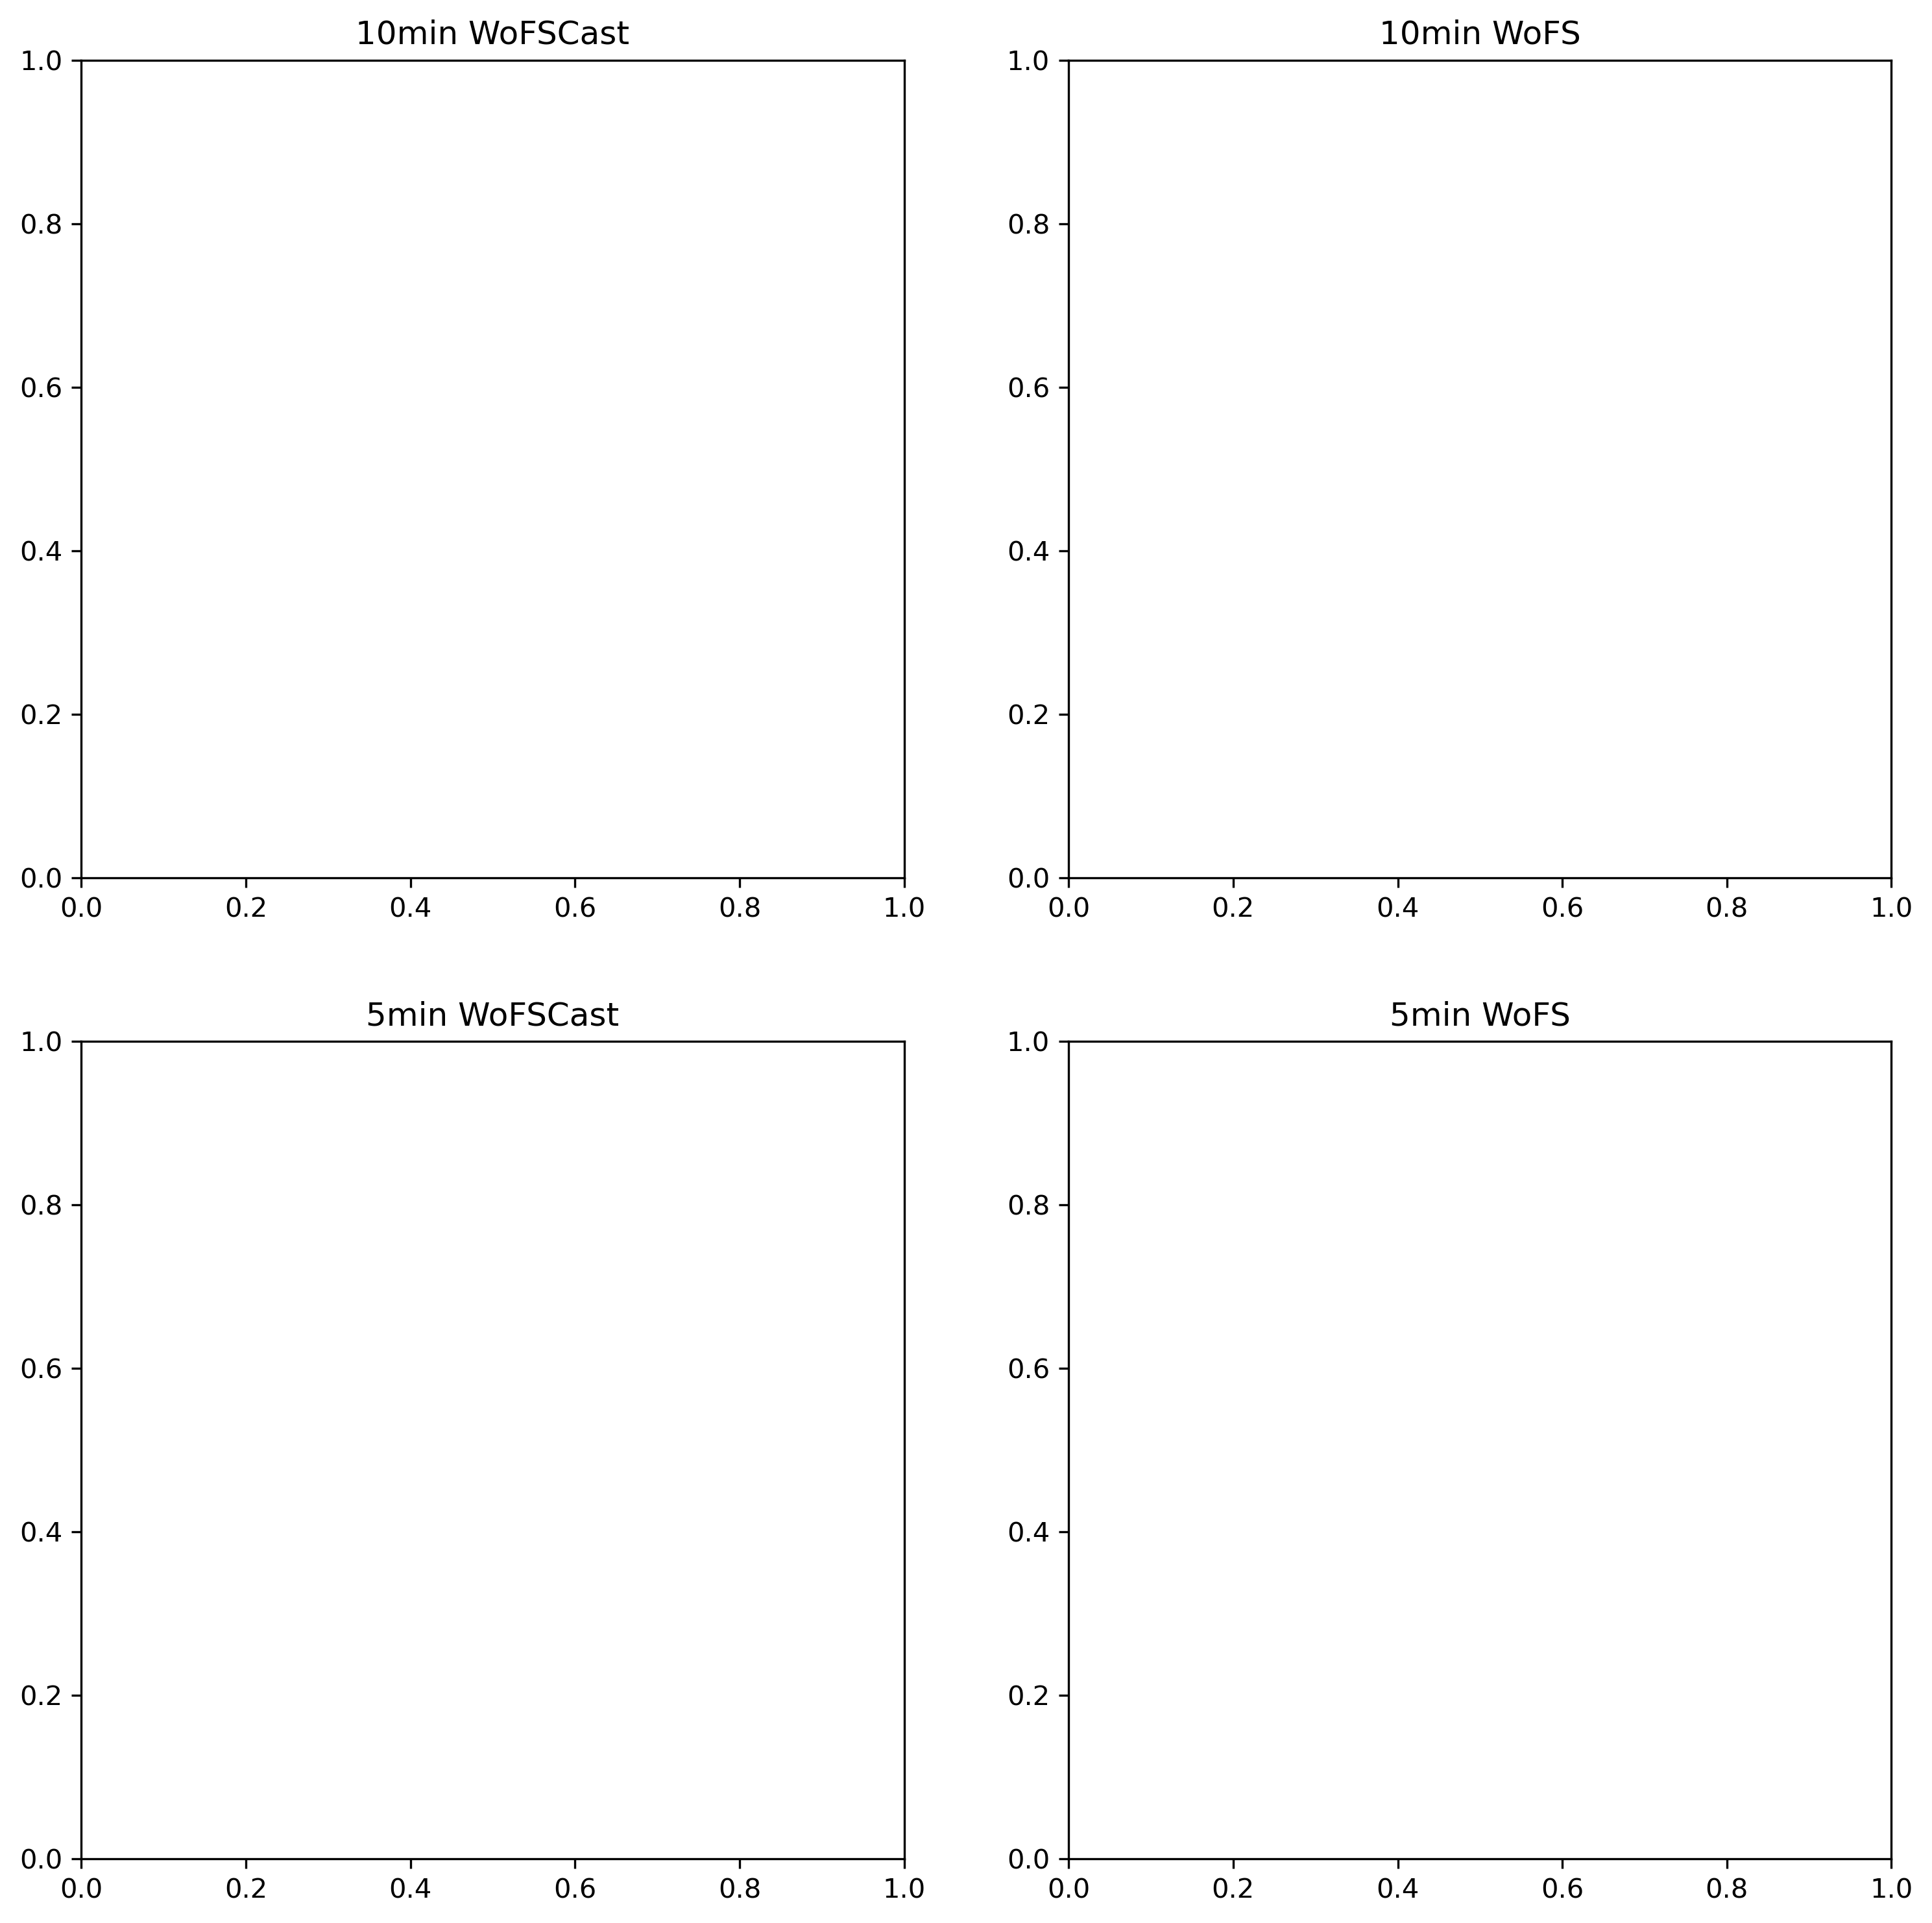

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assume predictions, targets_dict, linked_indices, WoFSColors, WoFSLevels are defined

fig, axes = plt.subplots(nrows=2, ncols=2, dpi=300, figsize=(12, 12,))
var = 'COMPOSITE_REFL_10CM'
levels = WoFSLevels.dz_levels_nws
cmap ='Spectral_r'
cmap = WoFSColors.

# Initialization function: plot the first frame
def init():
    for i, key in enumerate(predictions.keys()):
        for j in range(2):
            axes[i, j].clear()  # Clear the axis
            axes[i, j].set_title(f"{key.replace('wofscast_', '')} WoFSCast" if j == 0 else f"{key.replace('wofscast_', '')} WoFS")
    return axes.flatten()

# Update function: update the plots for each frame
def update(frame):
    idx = frame  # Use frame number as the index
    for ax in axes.flat:
        ax.clear()
    
    for i, key in enumerate(predictions.keys()): 
        if '5min' in key:
            t = linked_indices[idx][1]
        else:
            t = linked_indices[idx][0]
        
        pred = predictions[key].isel(batch=0, time=t)[var]
        tar = targets_dict[key].isel(batch=0, time=t)[var]
        
        # Plot the predictions and targets
        axes[i, 0].contourf(pred, levels=levels, cmap=cmap)
        axes[i, 1].contourf(tar, levels=levels, cmap=cmap)
        
        # Set titles again after clearing
        axes[i, 0].set_title(f"{key.replace('wofscast_', '')} WoFSCast")
        axes[i, 1].set_title(f"{key.replace('wofscast_', '')} WoFS")

    return axes.flatten()

# Create the animation
n_frames = len(linked_indices)
anim = FuncAnimation(fig, update, frames=n_frames, init_func=init)

HTML(anim.to_jshtml())

# Save or display the animation
#anim.save('gifs/wofscast_5min_vs_10min_animation.gif', writer="pillow", fps=3)  # Adjust fps as needed